In [30]:
import cv2
import os
import shutil
import numpy as np
from glob import glob
import random
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


In [31]:
def seed_everything(seed: int = 24):
    random.seed(seed)
    np.random.seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

seed_everything()

In [32]:
closed_path = '../dataset/realImg/eyes-only-22/closed'
opened_remain_path =  '../dataset/realImg/eyes-only-22/opened_remain'
opened_path = '../dataset/realImg/eyes-only-22/opened'

In [20]:
file_list = os.listdir(opened_path)
cnt = 0
num = 200

for file in file_list:
    if cnt < num:
        shutil.move(os.path.join(opened_path, file), os.path.join(opened_remain_path, file))
        cnt += 1
        print('wow', file)
    else:
        break
        

wow opened_eye_2039.jpg
wow opened_eye_2040.jpg
wow opened_eye_2041.jpg
wow opened_eye_2042.jpg
wow opened_eye_2043.jpg
wow opened_eye_2044.jpg
wow opened_eye_2045.jpg
wow opened_eye_2047.jpg
wow opened_eye_2048.jpg
wow opened_eye_2049.jpg
wow opened_eye_2050.jpg
wow opened_eye_2051.jpg
wow opened_eye_2052.jpg
wow opened_eye_2053.jpg
wow opened_eye_2054.jpg
wow opened_eye_2055.jpg
wow opened_eye_2056.jpg
wow opened_eye_2057.jpg
wow opened_eye_2058.jpg
wow opened_eye_206.jpg
wow opened_eye_2060.jpg
wow opened_eye_2061.jpg
wow opened_eye_2062.jpg
wow opened_eye_2063.jpg
wow opened_eye_2065.jpg
wow opened_eye_2066.jpg
wow opened_eye_2067.jpg
wow opened_eye_2068.jpg
wow opened_eye_2069.jpg
wow opened_eye_207.jpg
wow opened_eye_2070.jpg
wow opened_eye_2071.jpg
wow opened_eye_2072.jpg
wow opened_eye_2074.jpg
wow opened_eye_2075.jpg
wow opened_eye_2076.jpg
wow opened_eye_2077.jpg
wow opened_eye_2078.jpg
wow opened_eye_2079.jpg
wow opened_eye_208.jpg
wow opened_eye_2080.jpg
wow opened_eye_2081

In [21]:
print(len(os.listdir(opened_path)))

801


In [33]:
def get_dataset_paths(data_dir): # '../dataset/realImg/eyes-only-22'
    label_list = []

    opened_dir = os.path.join(data_dir, "opened")
    closed_dir = os.path.join(data_dir, "closed")

    opened_img_paths = glob(os.path.join(opened_dir, '*.jpg'))
    opened_img_paths.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    closed_img_paths = glob(os.path.join(closed_dir, '*.jpg'))
    closed_img_paths.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    # "opened" 레이블은 1,  "closed" 레이블은 0으로 지정
    label_list.extend([1] * len(opened_img_paths))
    label_list.extend([0] * len(closed_img_paths))
    img_path_list = opened_img_paths + closed_img_paths
    return img_path_list, label_list


In [34]:
from sklearn.utils import shuffle

def shuffle_dataset(img_path_list, label_list):
    img_path_list, label_list = shuffle(img_path_list, label_list, random_state=42)
    return img_path_list, label_list

In [35]:
img_path_list, label_list = get_dataset_paths('../dataset/realImg/eyes-only-22')
all_img_path, all_label = shuffle_dataset(img_path_list, label_list)

In [36]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, index):  
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
    
        if self.transforms is not None:
            image = self.transforms(image)
            
        if self.train_mode:
            label = self.label_list[index]
            return image, label
    
        else:
            return image

In [58]:
# train : test: val = 0.8 : 0.1 : 0.1

train_len = int(len(all_img_path)*0.8)
test_len = int(len(all_img_path)*0.1)
val_len = int(len(all_img_path)*0.1)
              
train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

test_img_path = all_img_path[train_len: train_len + test_len]
test_label = all_label[train_len: train_len + test_len]

val_img_path = all_img_path[train_len + test_len:]
val_label = all_label[train_len + test_len:]


In [38]:
print('train, test, val length:', train_len, test_len, val_len)

train, test, val length: 1248 156 156


In [39]:
# 하이퍼파라미터 
CFG = {
    'IMG_SIZE':128,
    'EPOCHS':10,
    'LEARNING_RATE':2e-2,
    'BATCH_SIZE':12,
    'SEED':24,
}

In [40]:
train_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) 

])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [12]:
# train_batches = len(train_loader)
# test_batches = len(test_loader)
# 
# print('total train imgs :', train_len,'/ total train batches :', train_batches)
# print('total test imgs :', val_len, '/ total test batches :', test_batches)

In [13]:
# 사진 확인하기
# train_features, train_labels = next(iter(train_loader))  
# img = train_features[0]
# label = train_labels[0]
# plt.imshow(img[0], cmap="gray")
# plt.show()
# print(f"Label: {label}")

In [41]:
class Model(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = torchvision.models.resnet18(weights=None)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(1000, 10)

    def forward(self, images):
        outputs = self.model(images)
        outputs = self.dropout(outputs)
        outputs = self.classifier(outputs)
        return outputs

In [42]:
# k-fold
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 4)
folds=[]
for trn_idx,val_idx in skf.split(train_img_path, train_label):
    folds.append((trn_idx,val_idx))


In [43]:
num_epochs = CFG['EPOCHS']
best_models = [] # 폴드별로 가장 validation acc가 높은 모델 저장
loss_for_epoch_for_4folds = [[] for _ in range(4)]
acc_for_epoch_for_4folds = [[] for _ in range(4)]

for i,fold in enumerate(range(4)):
    print('===============',i+1,'fold start===============')

    model = Model()
    optimizer = optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'] )
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size = 5,
                                                   gamma = 0.9) # learning rate scheduler 로 학습률 주기적 감소

    train_idx = folds[fold][0]
    val_idx = folds[fold][1]


    train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val_img_path, val_label, train_mode=True, transforms=test_transform)
    val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)


    val_acc_max = 0.94
    val_loss_min = 0.2

    for epoch in range(num_epochs):
        train_loss_list = [] 
        val_loss_list = []  
        val_acc_list = []
        #모델 학습
        for i, (images, targets) in enumerate(train_loader):
            model.train()

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss_list.append(loss.item())

            if (i+1) % 20 == 0:
                print(f'Epoch: {epoch} - Loss: {loss:.6f}')
                
        train_loss = np.mean(train_loss_list)


        # 모델 검증
        for i, (images, targets) in enumerate(val_loader):
            model.eval()

            with torch.no_grad():
                outputs = model(images)
                val_loss = criterion(outputs,targets)

                preds = torch.argmax(outputs, dim=1)

                batch_acc = (preds==targets).float().mean() # boolean 값의 평균

                val_loss_list.append(val_loss.item())
                val_acc_list.append(batch_acc.item())

        val_loss = np.mean(val_loss_list)
        val_acc = np.mean(val_acc_list)

        loss_for_epoch_for_4folds[fold].append(val_loss)
        acc_for_epoch_for_4folds[fold].append(val_acc)
        
        print(f'Epoch: {epoch} - valid Loss: {val_loss:.6f} - valid_acc : {val_acc:.6f}')

        # 정확도 기준 성능 좋은 모델 / 혹은 loss 기준 가능

        if val_acc_max < val_acc:
            valid_acc_max = val_acc
            best_models.append(model)
            print('model save, model val acc : ', val_acc)

        if val_loss_min > val_loss:
            val_loss_min = val_loss

    # lr 조절
    lr_scheduler.step()
print('Train finished, best_models size : ',len(best_models))

=============== 1 fold start===============
Epoch: 0 - Loss: 57.123856
Epoch: 0 - Loss: 14.996948
Epoch: 0 - Loss: 1.065353
Epoch: 0 - Loss: 0.998608
Epoch: 0 - Loss: 0.516020
Epoch: 0 - valid Loss: 0.625138 - valid_acc : 0.634615
Epoch: 1 - Loss: 0.618266
Epoch: 1 - Loss: 0.761005
Epoch: 1 - Loss: 0.332558
Epoch: 1 - Loss: 0.525214
Epoch: 1 - Loss: 0.267751
Epoch: 1 - valid Loss: 0.540265 - valid_acc : 0.711538
Epoch: 2 - Loss: 0.635267
Epoch: 2 - Loss: 0.193837
Epoch: 2 - Loss: 0.174171
Epoch: 2 - Loss: 0.428344
Epoch: 2 - Loss: 0.167497
Epoch: 2 - valid Loss: 0.174003 - valid_acc : 0.923077
Epoch: 3 - Loss: 0.697145
Epoch: 3 - Loss: 0.048263
Epoch: 3 - Loss: 0.186501
Epoch: 3 - Loss: 0.030383
Epoch: 3 - Loss: 0.088281
Epoch: 3 - valid Loss: 0.165913 - valid_acc : 0.929487
Epoch: 4 - Loss: 0.007487
Epoch: 4 - Loss: 0.472981
Epoch: 4 - Loss: 0.158771
Epoch: 4 - Loss: 0.076269
Epoch: 4 - Loss: 0.807402
Epoch: 4 - valid Loss: 0.185511 - valid_acc : 0.935897
Epoch: 5 - Loss: 0.121408
Epo

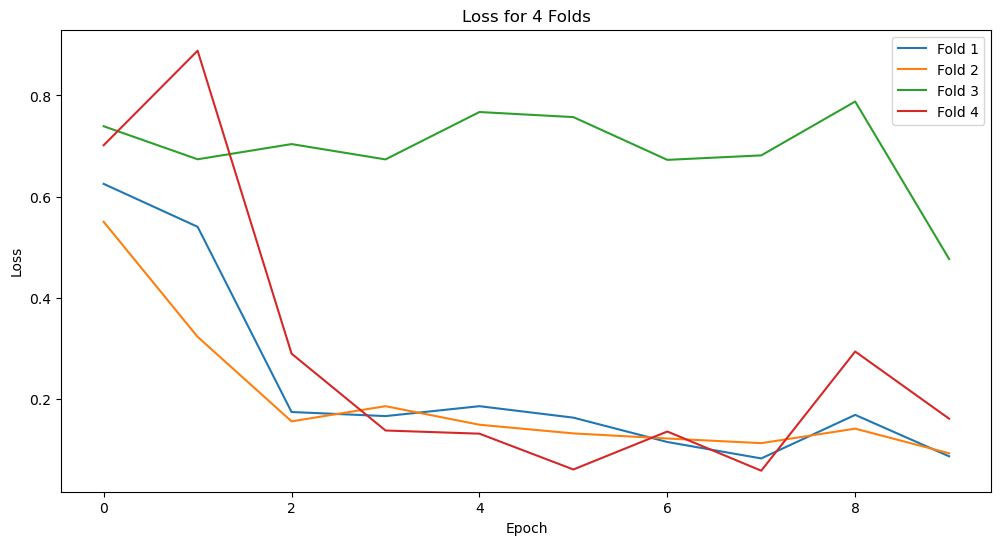

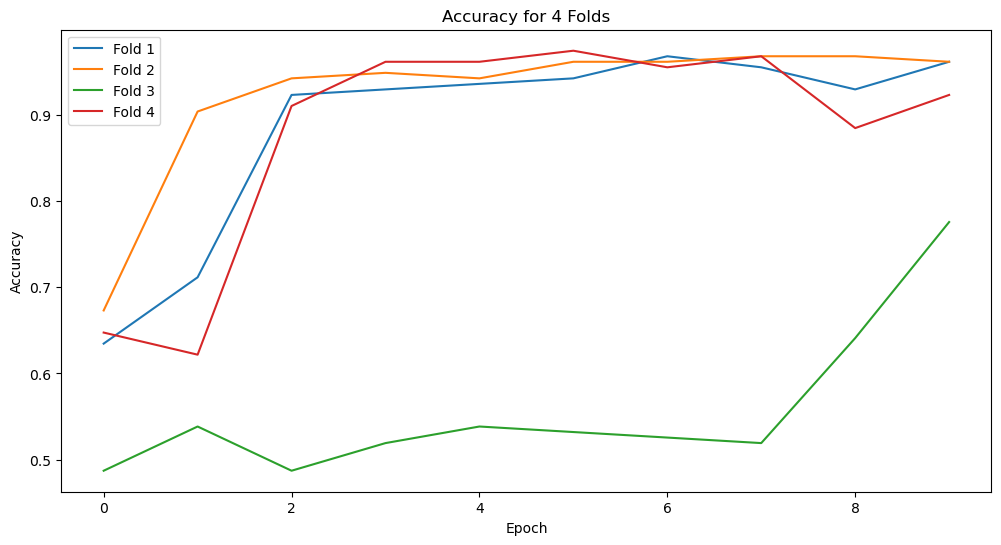

In [44]:
import matplotlib.pyplot as plt

# epoch 별 손실 그래프 그리기
plt.figure(figsize=(12, 6))
for fold in range(4):
    plt.plot(range(num_epochs), loss_for_epoch_for_4folds[fold], label=f'Fold {fold + 1}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for 4 Folds')
plt.show()

# 에폭별 정확도 그래프 그리기
plt.figure(figsize=(12, 6))
for fold in range(4):
    plt.plot(range(num_epochs), acc_for_epoch_for_4folds[fold], label=f'Fold {fold + 1}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for 4 Folds')
plt.show()

In [47]:
model_folder = 'E:\\2023\\2023_1_1\\comp\\saved_models_22'
model_template = 'model_fold_{}.pth'

# 폴드별로 학습한 모델을 저장
for i, best_model in enumerate(best_models):
    model_path = os.path.join(model_folder, model_template.format(i + 1))
    torch.save(best_model.state_dict(), model_path)
    print(f'Model {i + 1} saved to {model_path}')

# 테스트 데이터 예측
test_dataset = CustomDataset(test_img_path, test_label, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

preds = []
for id in range(1, len(best_models) + 1):
    model_path = os.path.join(model_folder, model_template.format(id))
    if os.path.exists(model_path):
        print(f'Loading model {id}')

        model = Model()
        model.load_state_dict(torch.load(model_path))

        model.eval()

        y_pred = []
        with torch.no_grad():
            for i, inputs in enumerate(test_loader):
                outputs = model(inputs).detach().cpu().numpy()
                y_pred.extend(outputs.argmax(axis=1).astype(int))
        preds.append(y_pred)
    else:
        print(f'Model {id} not found.')


Model 1 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_1.pth
Model 2 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_2.pth
Model 3 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_3.pth
Model 4 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_4.pth
Model 5 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_5.pth
Model 6 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_6.pth
Model 7 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_7.pth
Model 8 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_8.pth
Model 9 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_9.pth
Model 10 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_10.pth
Model 11 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_11.pth
Model 12 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_12.pth
Model 13 saved to E:\2023\2023_1_1\comp\saved_models_22\model_fold_13.pth
Model 14 saved to E:\2023\2023_1_1\comp\saved_models_22\

In [59]:
from sklearn.metrics import accuracy_score

# 정답 레이블
true_labels = test_label 

# 각 폴드별 정확도 계산 및 출력
for i, fold_preds in enumerate(preds):
    fold_accuracy = accuracy_score(true_labels, fold_preds)
    #print('preds:', fold_preds, 'true', true_labels)
    print(f'Fold {i + 1} Accuracy: {fold_accuracy:.6f}')

# 폴드별 정확도를 이용하여 가장 성능이 높은 모델 결정
best_fold_idx = np.argmax([accuracy_score(true_labels, fold_preds) for fold_preds in preds])
best_fold_accuracy = accuracy_score(true_labels, preds[best_fold_idx])
print(f'Best Model is from Fold {best_fold_idx + 1} with Accuracy: {best_fold_accuracy:.6f}')


Fold 1 Accuracy: 0.955128
Fold 2 Accuracy: 0.955128
Fold 3 Accuracy: 0.955128
Fold 4 Accuracy: 0.955128
Fold 5 Accuracy: 0.955128
Fold 6 Accuracy: 0.955128
Fold 7 Accuracy: 0.955128
Fold 8 Accuracy: 0.955128
Fold 9 Accuracy: 0.955128
Fold 10 Accuracy: 0.955128
Fold 11 Accuracy: 0.955128
Fold 12 Accuracy: 0.955128
Fold 13 Accuracy: 0.903846
Fold 14 Accuracy: 0.903846
Fold 15 Accuracy: 0.903846
Fold 16 Accuracy: 0.903846
Fold 17 Accuracy: 0.903846
Best Model is from Fold 1 with Accuracy: 0.955128


In [62]:
# 이미지 추론 결과 확인
model_path = '../saved_models_22/model_fold_1.pth'  
model = Model()  
model.load_state_dict(torch.load(model_path))
model.eval()

# 1 : closed, 0 : opened
#image_path = '../dataset/realImg/eyes-only-22/closed/closed_eye_0102.jpg'
image_path = '../dataset/realImg/eyes-only-22/opened/opened_eye_231.jpg'
#image_path = 'E:\im\KakaoTalk_20231101_220923687.png'
image = cv2.imread(image_path)  
img = cv2.imread(image_path)

image = image.astype(np.float32) / 255.0
image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()

with torch.no_grad():
    output = model(image)

predicted_class = output.argmax(dim=1).item()
print(f'Predicted Class: {predicted_class}')
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

Predicted Class: 0
